# Imports & Functions

In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import odeint
from scipy.linalg import solve_continuous_are
from sympy import *
from sympy.physics.mechanics import init_vprinting
from sympy.physics.vector import dynamicsymbols
from IPython.display import Math

init_vprinting()

In [2]:
# Configure plot parameters
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42  # Change from Type 3 to TrueType font type
mpl.rcParams['ps.fonttype'] = 42   # for making EPS files compatible with PDF
plt.rcParams.update({"font.size": 8, "font.family": "serif"})  # , "text.usetex": True})
dflt_figsize = (3.25, 2.0)
%matplotlib inline

# System definition

In [3]:
n = 2
m = 1

i_d, i_q = dynamicsymbols('i_d, i_q')
Dv, delta = symbols('\Delta{V}, \delta')
x = Matrix([[i_d], [i_q]])
u = Matrix([[Dv], [delta]])
r, l, w, k1, k2, v, e = symbols(r'R, L, \omega, k1, k2, V, E')
A_sys = Matrix([[-r/l, w], [-w, -r/l]])
B_sys = Matrix([[1/l, 0], [0, v/l]])
b_sys = Matrix([[0], [(-e)/l]])

sys_diff_eqs = latex(diff(x))+'='+latex(A_sys)+latex(x)+'+'+latex(B_sys)+latex(u)
Math(sys_diff_eqs)

<IPython.core.display.Math object>

In [4]:
# Only using angle input for this work
B_sys = Matrix([[0], [v/l]])

sys_diff_eqs = latex(diff(x))+'='+latex(A_sys)+latex(x)+'+'+latex(B_sys)+latex(u[1])
Math(sys_diff_eqs)

<IPython.core.display.Math object>

In [5]:
# Numeric parameters for the inverter system
s_rated = 1500.  # Rated power (W)
f_nom = 60.  # Nominal frequency (Hz)
v_nom = 120.  # Vrms LN (V)
i_nom = s_rated / (3 * v_nom)  # (A)
mag_lim = i_nom * 1.2  # Current magnitude limit (A)

v_val = np.sqrt(2)*v_nom  # Inverter voltage magnitude
e_val = np.sqrt(2)*v_nom  # Grid-side voltage magnitude (V)
omega_nom = f_nom * 2*np.pi  # Nominal frequency (rad)

# RL line parameters
r_val = 1.3 #0.15 # (Ohms)
l_val = 3.5e-3 # (H)

param_subs = {r: r_val, l: l_val, v: v_val, w: omega_nom, e: e_val}

In [6]:
"""
For the results in the associated paper we mistakenly had the voltage magnitudes
set to v_nom instead of sqrt(2)*v_nom. The same trends in the results are seen.
To reproduce the exact results from the paper uncomment the lines of code below.
""";
v_val = v_nom  # Inverter voltage magnitude
e_val = v_nom  # Grid-side voltage magnitude (V)
param_subs = {r: r_val, l: l_val, v: v_val, w: omega_nom, e: e_val}

In [7]:
# l/r ratio
(l_val*omega_nom) / r_val

1.014976088082856

# Safe Linear Feedback Controller

In [8]:
def safe_k(A, B, tol=1e-5, xref=None, verbose=False):
  """
  Given a linear system (A, B) such that  A + A.T < 0,  A^{-1} B != 0,
  solves for a linear feedback matrix K such that the closed loop linear system
  A - B K is safe given a circular state magnitude constraint.

  - tol: A tolerance value to ensure the eigenvalue safety inequality holds
  - verbose: If true prints the objective value of the solution
  """

  # Find a feasible x* value if not provided
  xref = np.linalg.inv(A) @ B if xref is None else xref
  xref_norm = xref / np.sqrt((xref.T @ xref))

  ### Define optimization variables ###
  K_cp = cp.Variable(B.shape[::-1])  # Feedback controller
  lambda_A_fb = cp.Variable(1)  # Eigenvalue of A_fb associated with x*

  ### Define constraints ###
  constraints = []

  A_fb = (A - B @ K_cp)
  constraints += [lambda_A_fb * xref_norm == A_fb.T @ xref_norm]  # Eigenvalue
  constraints += [cp.lambda_max(A_fb + A_fb.T) <= lambda_A_fb - tol]  # Safety
  constraints += [A_fb << 0]  # Stability

  ### Define objective function ###
  objective = cp.norm(K_cp, 2)

  ### Create the optimization problem ###
  problem = cp.Problem(cp.Minimize(objective), constraints)

  ### Solve the optimization problem ###
  problem.solve()

  converged = problem.status == cp.OPTIMAL
  if not converged:
      print("Optimization problem did not converge! %s" % problem.status)

  # Extract the results
  objective_value = problem.value
  K_num = K_cp.value

  if verbose:
    print("Objective:", objective_value)

  return K_num, converged, problem.status

## Controller Design

In [9]:
# Get numerical matrices for the optimization problem
A_num = np.array(A_sys.subs(param_subs)).astype(np.float64)
B_num = np.array(B_sys.subs(param_subs)).astype(np.float64)

print("A: \n", A_num, ",\nB: \n", B_num)

A: 
 [[-371.42857143  376.99111843]
 [-376.99111843 -371.42857143]] ,
B: 
 [[    0.        ]
 [34285.71428571]]


In [10]:
# Solve for the feasible x_ref values
x_ref = Matrix(MatrixSymbol("x^*", n, 1))
xref2 = solve((A_sys @ x_ref)[0, 0], x_ref[1, 0])[0]
xref = Matrix([[x_ref[0]], [xref2]])
xref_norm = xref / sqrt((xref.T @ xref)[0])

xref_num = np.array(xref_norm.subs(param_subs).subs(x_ref[0], 1)).astype(np.float64)
print(xref_num)

[[0.7123426]
 [0.7018319]]


In [11]:
# Solve for a safe K
K_safe, _, _ = safe_k(A_num, B_num, xref=xref_num, tol=1e-2)
print("Safe K:", K_safe)

Safe K: [[-0.0110925   0.01106475]]


In [12]:
# Resulting closed-loop system dynamics
A_fb = A_num - B_num @ K_safe
print("Eigenvalues: ", np.linalg.eigvals(A_fb))
print("Closed-loop System A:\n", A_fb)

Eigenvalues:  [-368.15448391 -754.06554203]
Closed-loop System A:
 [[-371.42857143  376.99111843]
 [   3.32312055 -750.79145451]]


In [13]:
# Define the dynamics function for safe K simulation
x = MatrixSymbol("x", n, 1)
u = MatrixSymbol("u", m, 1)
x_ref = MatrixSymbol("x^*", n, 1)

fx = A_num @ x
gx = B_num

# Solve for u* and define the linear feedback control function
eq_ref = solve(Matrix(fx).subs(zip(x, x_ref)) + Matrix(gx).subs(zip(x, x_ref)) @ Matrix(u), [*Matrix(u), x_ref[1]])
u_ctrl_K = eq_ref[u[0]] - K_safe @ (x - x_ref)

t = symbols('t')
fx_lambda = lambdify([list(x), t], fx)
gx_lambda = lambdify([list(x), t], gx)
u_K_lambda = lambdify([Matrix(x), t, Matrix(x_ref)], list(u_ctrl_K))

def fxdot_safeK(x, t, x_ref):
  u_ctrl = np.array([u_K_lambda(x, t, x_ref)])
  xdot = fx_lambda(x, t) + gx_lambda(x, t) @ u_ctrl[:, None]
  return xdot.flatten()

In [14]:
# Simulate the system for a range of initial conditions
dt = 1e-4
ts = np.arange(0, 0.1, dt)
rads = np.linspace(0, 2*np.pi, 50)
x0s = mag_lim*np.vstack([np.sin(rads), np.cos(rads)]).T

x_ref_val = -mag_lim*xref_num.flatten()

xs_vals = []
for x0 in x0s:
  xs = odeint(fxdot_safeK, x0, ts, args=(x_ref_val,))
  xs_vals.append(xs)

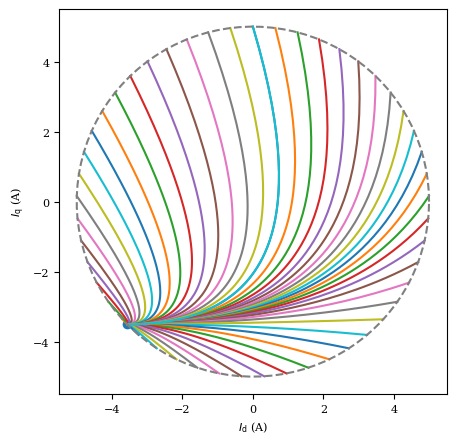

In [15]:
# Plot circular magnitude limit & safe state trajectories
fig = plt.figure(figsize=(5,5))
rads = np.linspace(0, 2*np.pi, 100)
for xs in xs_vals:
  plt.plot(xs[:, 0], xs[:, 1])
plt.scatter(x_ref_val[0], x_ref_val[1])
plt.xlabel("$I_\mathrm{d}$ (A)")
plt.ylabel("$I_\mathrm{q}$ (A)")
plt.plot(mag_lim*np.cos(rads), mag_lim*np.sin(rads), color='grey', linestyle='--');

# CBF Safety Filter

We select the barrier function $h(x) = |I|_\mathrm{lim} - x^\top x$.

For the system to be safe we require $h(x) \geq 0$, which is always true if $u$ is selected such that
$$
\dot{h}(x, u) \geq -\alpha h(x) \quad\forall\quad \{x \hspace{0.5em}|\hspace{0.5em} h(x) = 0\}.
$$

We select the Lyapunov function $V(x) = x^\top x$. For the system to be stable we require $\dot{V}(x, u) \leq 0$.

### Controller Design

In [16]:
def compute_hdot(fx, gx, hx, x, r, params, alpha=100, dhdx=None):
  # Defines functions for calculating the a and b values of the safety constraint
  dhdx = diff(hx, x).T if dhdx is None else dhdx
  lgh = simplify(dhdx @ gx)
  lfh = simplify(dhdx @ fx)

  for arg in r:
    params.pop(arg) if arg in params else None
  t = Symbol('t')
  xtr = [x, t, r]
  fa = lambdify(xtr, (lgh).subs(params), modules=["numpy"])
  fb = lambdify(xtr, (-alpha * hx - lfh[0]).subs(params), modules=["numpy"])
  return fa, fb

def compute_Vdot(fx, gx, Vx, x, x_ref, r, params, alpha=0, dVdx=None):
  # Defines functions for calculating the a and b values of the stability constraint
  dVdx = diff(Vx, x).T if dVdx is None else dVdx
  lgV = simplify(dVdx @ gx)
  lfV = simplify(dVdx @ fx)

  for arg in r:
    params.pop(arg) if arg in params else None
  t = Symbol('t')
  xtr = [x, t, x_ref, r]
  fa = lambdify(xtr, (lgV).subs(params), modules=["numpy"])
  fb = lambdify(xtr, (-alpha * Vx - lfV[0]).subs(params), modules=["numpy"])
  return fa, fb

# Algorithm 1
def cbf_cf(fa_cbf, fb_cbf, fa_clf, fb_clf, u0, x, t, xref, r, P=None, Pinv=None):
  # Closed-form solution to a QP with two constraints with u0 in R^1
  a_cbf = fa_cbf(x, t, r)
  b_cbf = fb_cbf(x, t, r)
  a_clf = fa_clf(x, t, xref, r)
  b_clf = fb_clf(x, t, xref, r)

  u_ub = np.inf
  u_lb = -np.inf
  if a_cbf >= 0:
    u_lb = np.maximum(u_lb, b_cbf / a_cbf)
  else:
    u_ub = np.minimum(u_ub, b_cbf / a_cbf)
  if a_clf >= 0:
    u_ub = np.minimum(u_ub, b_clf / a_clf)
  else:
    u_lb = np.maximum(u_lb, b_clf / a_clf)

  u_bar = np.minimum(u_ub, np.maximum(u_lb, u0))
  return u_bar

def cbf(fa_cbf, fb_cbf, fa_clf, fb_clf, u_val, x, xref, r = []):
  # Control barier function safety filter function
  u_val = np.array([[u_val]]) if not isinstance(u_val, np.ndarray) else u_val
  fa_cbf_, fb_cbf_ = fa_cbf(x, t, r), fb_cbf(x, t, r)
  fa_clf_, fb_clf_ = fa_clf(x, t, xref, r), fb_clf(x, t, xref, r)

  if np.any(np.abs(fa_cbf_) >= 1e-5) and np.any(np.abs(fa_clf_) >= 1e-2):  # Numerical issues with CLF solution when x gets near x*
    if not (fa_cbf_ @ u_val - fb_cbf_ >= 0) or not (fa_clf_ @ u_val - fb_clf_ <= 0):
      u_val = cbf_cf(fa_cbf, fb_cbf, fa_clf, fb_clf, u_val, x, t, xref, r)
      u_val = u_val.astype(np.float64)

  return u_val

In [17]:
# Find a baseline controller

# LQR costs
Q = np.eye(2)
R = 0.1*B_num[1]*np.eye(1)

P = solve_continuous_are(A_num, B_num, Q, R)  # Solve the continuous-time Algebraic Riccati equation
K_cbf = np.dot(np.dot(np.linalg.inv(R), B_num.T), P)  # Compute the LQR gain

# Print LQR feedback matrix
print("LQR K:", K_cbf)

LQR K: [[0.00091197 0.00988098]]


In [18]:
# Baseline controller closed-loop system eigenvalues
print("Eigenvalues: ", np.linalg.eigvals(A_num - B_num @ K_cbf))

Eigenvalues:  [-540.81688039+353.86077261j -540.81688039-353.86077261j]


In [19]:
# Simulate the system for a range of initial conditions
from scipy.integrate import odeint

x = Matrix(MatrixSymbol("x", 2, 1))
u = Matrix(MatrixSymbol("u", 1, 1))
x_ref = Matrix(MatrixSymbol("x^*", 2, 1))
hx = mag_lim**2 - (x.T @ x)[0]
Vx = ((x - x_ref).T @ (x - x_ref))[0]
fx = A_num @ x
gx = B_num

# Solve for u* and define the linear feedback control function
eq_ref = solve(Matrix(fx).subs(zip(x, x_ref)) + Matrix(gx).subs(zip(x, x_ref)) @ Matrix(u), [*Matrix(u), x_ref[1]])
u_ctrl = eq_ref[u[0]] - (K_cbf @ (x - x_ref))[0]

t = symbols('t')
fx_lambda = lambdify([list(x), t], fx)
gx_lambda = lambdify([list(x), t], gx)
u_lambda = lambdify([list(x), t, list(x_ref)], u_ctrl)

param_inputs = []
params = param_subs
fa_cbf, fb_cbf = compute_hdot(fx, gx, hx, x, param_inputs, params, alpha=1000)
fa_clf, fb_clf = compute_Vdot(fx, gx, Vx, x, x_ref, param_inputs, params, alpha=0)

def fxdot_cbf(x, t, x_ref, filter=True):
  u_ctrl = np.array([u_lambda(x, t, x_ref)])
  if filter:
    u_ctrl = cbf(fa_cbf, fb_cbf, fa_clf, fb_clf, u_ctrl, x, x_ref)  # QP closed-form safety filter solution
  # else:
  #   u_cbf = np.array(u_ctrl)

  xdot = fx_lambda(x, t) + gx_lambda(x, t) @ u_ctrl[:, None]
  return xdot.flatten()

# Comparison of Approaches

## $x_0 \in \partial \mathcal{S}$

In [20]:
# Simulate with each controller for comparison
dt = 1e-5
ts = np.arange(0, 0.1, dt)
n_tests = 100
rads = np.linspace(0, 2*np.pi - 2*np.pi/n_tests, n_tests)
x0s = mag_lim*np.vstack([np.sin(rads), np.cos(rads)]).T

x_ref_val = mag_lim*xref_num.flatten()
print('x* = ', x_ref_val)

xs_vals = {}
xs_vals["cbf"], xs_vals["lqr"], xs_vals["safek"] = [], [], []
for i, x0 in enumerate(x0s):
  print('Test %s: x(0) = %s' % (i+1, x0))
  xs_cbf = odeint(fxdot_cbf, x0, ts, args=(x_ref_val, True))  # CBF filter=True
  xs_lqr = odeint(fxdot_cbf, x0, ts, args=(x_ref_val, False))  # CBF filter=False
  xs_safek = odeint(fxdot_safeK, x0, ts, args=(x_ref_val,))
  xs_vals["cbf"].append(xs_cbf)
  xs_vals["lqr"].append(xs_lqr)
  xs_vals["safek"].append(xs_safek)

x* =  [3.561713   3.50915952]
Test 1: x(0) = [0. 5.]
Test 2: x(0) = [0.3139526  4.99013364]
Test 3: x(0) = [0.62666617 4.96057351]
Test 4: x(0) = [0.93690657 4.91143625]
Test 5: x(0) = [1.24344944 4.84291581]
Test 6: x(0) = [1.54508497 4.75528258]
Test 7: x(0) = [1.84062276 4.64888243]
Test 8: x(0) = [2.12889646 4.52413526]
Test 9: x(0) = [2.40876837 4.3815334 ]
Test 10: x(0) = [2.67913397 4.22163963]
Test 11: x(0) = [2.93892626 4.04508497]
Test 12: x(0) = [3.18711995 3.85256621]
Test 13: x(0) = [3.42273553 3.64484314]
Test 14: x(0) = [3.64484314 3.42273553]
Test 15: x(0) = [3.85256621 3.18711995]
Test 16: x(0) = [4.04508497 2.93892626]
Test 17: x(0) = [4.22163963 2.67913397]
Test 18: x(0) = [4.3815334  2.40876837]
Test 19: x(0) = [4.52413526 2.12889646]
Test 20: x(0) = [4.64888243 1.84062276]
Test 21: x(0) = [4.75528258 1.54508497]
Test 22: x(0) = [4.84291581 1.24344944]
Test 23: x(0) = [4.91143625 0.93690657]
Test 24: x(0) = [4.96057351 0.62666617]
Test 25: x(0) = [4.99013364 0.31395

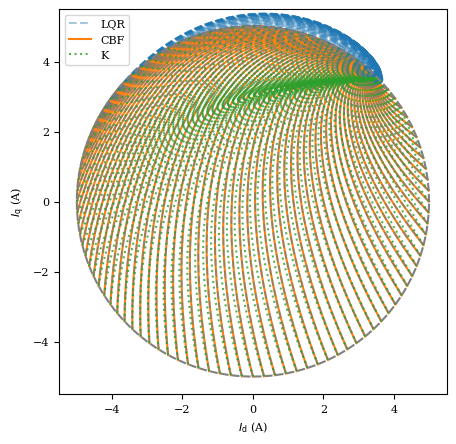

In [21]:
# Plot Idq trajectories alongside circular magnitude limit
fig = plt.figure(figsize=(5,5))
rads = np.linspace(0, 2*np.pi, 100)
for xs_lqr, xs_cbf, xs_safek in zip(xs_vals["lqr"], xs_vals["cbf"], xs_vals["safek"]):
  plt.plot(xs_lqr[:, 0], xs_lqr[:, 1], linestyle="--", alpha=0.4, color='C0');
  plt.plot(xs_cbf[:, 0], xs_cbf[:, 1], color='C1', zorder=0);
  plt.plot(xs_safek[:, 0], xs_safek[:, 1], linestyle=":", alpha=0.8, color='C2');

plt.scatter(x_ref_val[0], x_ref_val[1])
plt.xlabel("$I_\mathrm{d}$ (A)")
plt.ylabel("$I_\mathrm{q}$ (A)")
plt.legend(['LQR', 'CBF', 'K'], loc='upper left')
plt.xlim(-mag_lim*1.1, mag_lim*1.1)
plt.ylim(-mag_lim*1.1, mag_lim*1.1)
plt.plot(mag_lim*np.cos(rads), mag_lim*np.sin(rads), color='grey', linestyle='--');

In [22]:
# Convert simulation data to numpy arrays
xs_vals_arr_cbf_ = np.array(xs_vals['cbf'])
xs_vals_arr_lqr_ = np.array(xs_vals['lqr'])
xs_vals_arr_K_ = np.array(xs_vals['safek'])

tms = 1000*ts  # time array in milliseconds for plotting

In [23]:
# Check that every trajectory converged to x* in the simulation timeframe
for ctrl_name, xs_vals_ in xs_vals.items():
  x_err = np.linalg.norm(np.array(xs_vals_)[:, -1, :] - x_ref_val, axis=1)
  print("%s converged: " % ctrl_name, np.sum(x_err < 1e-4), ',', np.max(x_err))

cbf converged:  100 , 3.686474273235204e-11
lqr converged:  100 , 6.674227002009298e-11
safek converged:  100 , 5.187956743659117e-10


In [24]:
# Check how many trajectories are unsafe
for ctrl_name, xs_vals_ in xs_vals.items():
  x_norm_test_max = np.max(np.linalg.norm(np.array(xs_vals_)[:, :, :], axis=2) - mag_lim, axis=1)
  print("%s unsafe Trajectories: " % ctrl_name, np.sum(x_norm_test_max > 1e-5))

cbf unsafe Trajectories:  0
lqr unsafe Trajectories:  100
safek unsafe Trajectories:  0


In [25]:
# Calculate u* value
u_ref_val = np.float64(eq_ref[u[0]].subs(x_ref[0], x_ref_val[0]))

# Recompute inputs for cost calculations
us_vals_cbf = []
for i, xs in enumerate(xs_vals_arr_cbf_):
  print("Calculation Progress: %s / %s" % (i, xs_vals_arr_cbf_.shape[0])) if i % (xs_vals_arr_cbf_.shape[0] // 10) == 0 else None
  u_ctrl = u_lambda(xs.T, t, x_ref_val)
  u_cbf = np.array([cbf(fa_cbf, fb_cbf, fa_clf, fb_clf, u, x, x_ref_val)[0] for u, x in zip(u_ctrl, xs)])
  us_vals_cbf.append(u_cbf)

us_vals_lqr = []
for xs in xs_vals_arr_lqr_:
  u_ctrl = u_lambda(xs.T, t, x_ref_val)[None, :]
  us_vals_lqr.append(u_ctrl.T)

us_vals_K = []
for xs in xs_vals_arr_K_:
  u_ctrl = u_K_lambda(xs.T, t, x_ref_val)[0]
  us_vals_K.append(u_ctrl.T)

us_vals_arr_K_, us_vals_arr_cbf_, us_vals_arr_lqr_ = np.array(us_vals_K), np.array(us_vals_cbf), np.array(us_vals_lqr)

Calculation Progress: 0 / 100
Calculation Progress: 10 / 100
Calculation Progress: 20 / 100
Calculation Progress: 30 / 100
Calculation Progress: 40 / 100
Calculation Progress: 50 / 100
Calculation Progress: 60 / 100
Calculation Progress: 70 / 100
Calculation Progress: 80 / 100
Calculation Progress: 90 / 100


In [26]:
cost_scale = 1000*dt  # Scale the cost by this amount for the results

def LQR_cost(xs, us, Q, R, x_ref):
  cost = np.sum(LQR_series_cost(xs, us, Q, R, x_ref))
  return cost

def LQR_series_cost(xs, us, Q, R, x_ref, u_ref=0):
  state_costs = np.einsum('ij,jk,ik->i',xs - x_ref, Q, xs - x_ref)  # Equivalent to sum( (x - x*)^T Q (x - x*) for x in xs )
  input_costs = np.einsum('ij,jk,ik->i',us - u_ref, R, us - u_ref)  # Equivalent to sum( (u - u*)^T R (u - u*) for u in us)
  cost_arr = state_costs + input_costs
  return cost_arr

def LQR_single_cost(x, u, Q, R, x_ref):
  return (x - x_ref).T @ Q @ (x - x_ref) + u.T @ R @ u

In [27]:
# Cost calculations
K_series_costs = [LQR_series_cost(xs, us, Q, R, x_ref_val, u_ref_val) for xs, us in zip(xs_vals_arr_K_, us_vals_arr_K_)]
cbf_series_costs = [LQR_series_cost(xs, us, Q, R, x_ref_val, u_ref_val) for xs, us in zip(xs_vals_arr_cbf_, us_vals_arr_cbf_)]
lqr_series_costs = [LQR_series_cost(xs, us, Q, R, x_ref_val, u_ref_val) for xs, us in zip(xs_vals_arr_lqr_, us_vals_arr_lqr_)]

K_costs = [np.sum(costs) for costs in K_series_costs]
cbf_costs = [np.sum(costs) for costs in cbf_series_costs]
lqr_costs = [np.sum(costs) for costs in lqr_series_costs]

# Input cost
K_series_input_costs = [LQR_series_cost(np.zeros(xs.shape), us, Q, R, 0, u_ref_val) for xs, us in zip(xs_vals_arr_K_, us_vals_arr_K_)]
cbf_series_input_costs = [LQR_series_cost(np.zeros(xs.shape), us, Q, R, 0, u_ref_val) for xs, us in zip(xs_vals_arr_cbf_, us_vals_arr_cbf_)]
lqr_series_input_costs = [LQR_series_cost(np.zeros(xs.shape), us, Q, R, 0, u_ref_val) for xs, us in zip(xs_vals_arr_lqr_, us_vals_arr_lqr_)]

# State cost
K_series_state_costs = [LQR_series_cost(xs, np.zeros(us.shape), Q, R, x_ref_val, 0) for xs, us in zip(xs_vals_arr_K_, us_vals_arr_K_)]
cbf_series_state_costs = [LQR_series_cost(xs, np.zeros(us.shape), Q, R, x_ref_val, 0) for xs, us in zip(xs_vals_arr_cbf_, us_vals_arr_cbf_)]
lqr_series_state_costs = [LQR_series_cost(xs, np.zeros(us.shape), Q, R, x_ref_val, 0) for xs, us in zip(xs_vals_arr_lqr_, us_vals_arr_lqr_)]

In [28]:
# Display Costs
print('\t\t K \t\t\t CBF \t\t\t LQR')
print('Total:\t', cost_scale*np.mean(K_costs), '\t', cost_scale*np.mean(cbf_costs), '\t', cost_scale*np.mean(lqr_costs))

		 K 			 CBF 			 LQR
Total:	 82.22286809824547 	 59.15535866389148 	 58.57090696029621


In [29]:
# Select trajectories to plot
example_idx = np.array([55]) #np.array([27])  # Positive x*
print('x0 = ', x0s[example_idx])
xs_vals_arr_cbf = xs_vals_arr_cbf_[example_idx, :, :]
xs_vals_arr_lqr = xs_vals_arr_lqr_[example_idx, :, :]
xs_vals_arr_K = xs_vals_arr_K_[example_idx, :, :]

us_vals_arr_cbf = us_vals_arr_cbf_[example_idx, :]
us_vals_arr_lqr = us_vals_arr_lqr_[example_idx, :]
us_vals_arr_K = us_vals_arr_K_[example_idx, :]

x0 =  [[-1.54508497 -4.75528258]]


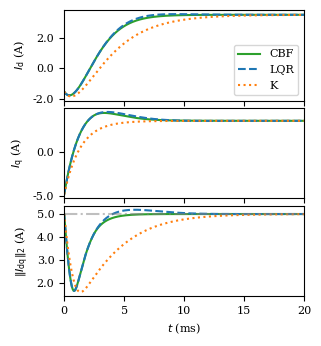

In [30]:
# Plot states versus time
colors = {"cbf": 'C2', "LQR": 'C0', "K": 'C1'}
linestyles = {"cbf": '-', "LQR": '--', "K": ':'}
fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[1]*1.75))

axs = []
axs.append(plt.subplot(3, 1, 1))
plt.plot(tms, xs_vals_arr_cbf[:, :, 0].T, label="CBF", color=colors["cbf"], linestyle=linestyles["cbf"])
plt.plot(tms, xs_vals_arr_lqr[:, :, 0].T, label="LQR", color=colors["LQR"], linestyle=linestyles["LQR"])
plt.plot(tms, xs_vals_arr_K[:, :, 0].T, label="K", color=colors["K"], linestyle=linestyles["K"])
plt.ylabel("$I_\mathrm{d}$ (A)")
plt.legend()
axs.append(plt.subplot(3, 1, 2))
plt.plot(tms, xs_vals_arr_cbf[:, :, 1].T, color=colors["cbf"], linestyle=linestyles["cbf"])
plt.plot(tms, xs_vals_arr_lqr[:, :, 1].T, color=colors["LQR"], linestyle=linestyles["LQR"])
plt.plot(tms, xs_vals_arr_K[:, :, 1].T, color=colors["K"], linestyle=linestyles["K"])
plt.ylabel("$I_\mathrm{q}$ (A)")
axs.append(plt.subplot(3, 1, 3))
plt.plot(tms, np.linalg.norm(xs_vals_arr_cbf[:, :, :], axis=2).T, color=colors["cbf"], linestyle=linestyles["cbf"])
plt.plot(tms, np.linalg.norm(xs_vals_arr_lqr[:, :, :], axis=2).T, color=colors["LQR"], linestyle=linestyles["LQR"])
plt.plot(tms, np.linalg.norm(xs_vals_arr_K[:, :, :], axis=2).T, color=colors["K"], linestyle=linestyles["K"])
plt.axhline(mag_lim, color='grey', linestyle='-.', label="$I_\mathrm{lim}$", alpha=0.5)
plt.ylabel("$\|I_\mathrm{dq} \|_2$ (A)")
plt.xlabel("$t$ (ms)")

for ax in axs[:2]:
  ax.set_xticklabels([])

from matplotlib.ticker import FormatStrFormatter
for ax in axs:
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  ax.set_xlim(0, 0.02*1000)

plt.tight_layout();
fig.subplots_adjust(hspace=0.08);

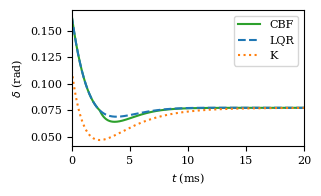

In [31]:
# Plot inputs versus time
fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[1]))

plt.plot(tms, us_vals_arr_cbf[:, :, 0].T, label="CBF", color=colors["cbf"], linestyle=linestyles["cbf"])
plt.plot(tms, us_vals_arr_lqr[:, :, 0].T, label="LQR", color=colors["LQR"], linestyle=linestyles["LQR"])
plt.plot(tms, us_vals_arr_K[:, :, 0].T, label="K", color=colors["K"], linestyle=linestyles["K"])
plt.ylabel(r"$\delta$ (rad)")
plt.xlabel(r"$t$ (ms)")
plt.legend()
plt.xlim(0, 1000*0.02)
axs = fig.axes

plt.tight_layout()

## Random $x^*, x_0$

In this section we test the controllers by run simulations with random $x^*$ values that satisfy $A x^* + B u^* = 0$ and $\|x^*\|_2 \leq |I|_\mathrm{max}$, and $x_0$ values that satisfy $\|x_0\|_2 \leq |I|_\mathrm{max}$.

In [32]:
dt = 1e-5
ts = np.arange(0, 0.1, dt)
n_tests = 100  # 1000 tests were run for the paper results.

rng = np.random.default_rng(seed=2024)

xs_test = {}
xs_test["cbf"], xs_test["lqr"], xs_test["safek"] = [], [], []

x_ref_tests = []
x0_tests = []
for i_test in range(n_tests):
  print
  x_ref_test = x_ref_val * 2*(rng.random() - 0.5)
  x0_rad = 2*np.pi* rng.random()
  x0_mag = mag_lim * rng.random()
  x0_test = np.array([x0_mag*np.cos(x0_rad), x0_mag*np.sin(x0_rad)])

  print('Test %s: x* = %s, x0 = %s' % (i_test+1, x_ref_test, x0_test)) if (i_test+1) % (n_tests//10) == 0 else None

  xs_cbf = odeint(fxdot_cbf, x0_test, ts, args=(x_ref_test, True))  # CBF filter=True
  xs_lqr = odeint(fxdot_cbf, x0_test, ts, args=(x_ref_test, False))  # CBF filter=False
  xs_safek = odeint(fxdot_safeK, x0_test, ts, args=(x_ref_test,))

  xs_test["cbf"].append(xs_cbf)
  xs_test["lqr"].append(xs_lqr)
  xs_test["safek"].append(xs_safek)

  x_ref_tests.append(x_ref_test)
  x0_tests.append(x0_test)

Test 10: x* = [-1.65003246 -1.62568604], x0 = [-0.04013641  0.35212889]
Test 20: x* = [-0.52999862 -0.52217843], x0 = [0.75133077 2.41146416]
Test 30: x* = [1.44528015 1.42395488], x0 = [1.12777025 0.82546263]
Test 40: x* = [2.88551878 2.84294262], x0 = [-0.69249775 -0.04217129]
Test 50: x* = [1.99589837 1.96644866], x0 = [3.31693927 0.13625737]
Test 60: x* = [-0.07264613 -0.07157423], x0 = [-0.33246167  0.57873279]
Test 70: x* = [-3.13911902 -3.09280096], x0 = [0.90360517 3.9579139 ]
Test 80: x* = [1.43434347 1.41317956], x0 = [1.14250386 3.57041464]
Test 90: x* = [-0.57476468 -0.56628396], x0 = [-0.84209866 -2.98350686]
Test 100: x* = [0.69055215 0.68036297], x0 = [-0.27652366  4.60888295]


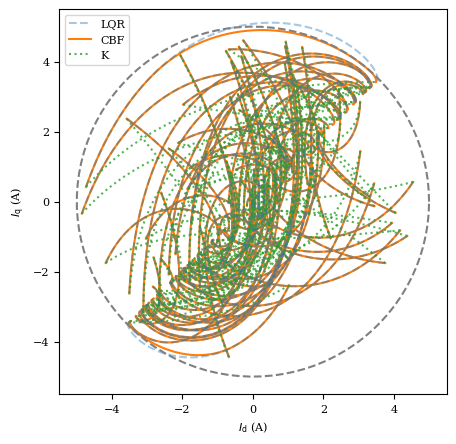

In [33]:
# Plot Idq trajectories with the circular magnitude limit
fig = plt.figure(figsize=(5,5))
rads = np.linspace(0, 2*np.pi, 100)
for xs_lqr, xs_cbf, xs_safek in zip(xs_test["lqr"], xs_test["cbf"], xs_test["safek"]):
  plt.plot(xs_lqr[:, 0], xs_lqr[:, 1], linestyle="--", alpha=0.4, color='C0');
  plt.plot(xs_cbf[:, 0], xs_cbf[:, 1], color='C1', zorder=0);
  plt.plot(xs_safek[:, 0], xs_safek[:, 1], linestyle=":", alpha=0.8, color='C2');

plt.xlabel("$I_\mathrm{d}$ (A)")
plt.ylabel("$I_\mathrm{q}$ (A)")
plt.legend(['LQR', 'CBF', 'K'], loc='upper left')
plt.xlim(-mag_lim*1.1, mag_lim*1.1)
plt.ylim(-mag_lim*1.1, mag_lim*1.1)
plt.plot(mag_lim*np.cos(rads), mag_lim*np.sin(rads), color='grey', linestyle='--');

In [34]:
# Check that every trajectory converged to x* in the simulation timeframe
for ctrl_name, xs_vals_ in xs_test.items():
  x_err = np.linalg.norm(np.array(xs_vals_)[:, -1, :] - np.array(x_ref_tests), axis=1)
  print("%s converged: " % ctrl_name, np.sum(x_err < 1e-4), ',', np.max(x_err))

cbf converged:  100 , 5.656050446781176e-11
lqr converged:  100 , 5.656050446781176e-11
safek converged:  100 , 3.070189899391969e-10


In [35]:
# Check how many trajectories are unsafe
for ctrl_name, xs_vals_ in xs_test.items():
  x_norm_test_max = np.max(np.linalg.norm(np.array(xs_vals_)[:, :, :], axis=2) - mag_lim, axis=1)
  print("%s unsafe Trajectories: " % ctrl_name, np.sum(x_norm_test_max > 1e-5))

cbf unsafe Trajectories:  0
lqr unsafe Trajectories:  2
safek unsafe Trajectories:  0


In [36]:
# Convert simulation data to numpy arrays
xs_vals_arr_cbf_test = np.array(xs_test['cbf'])
xs_vals_arr_lqr_test = np.array(xs_test['lqr'])
xs_vals_arr_K_test = np.array(xs_test['safek'])

In [37]:
# Recompute inputs for cost calculations
us_vals_cbf = []
for i, (xs, x_ref_test) in enumerate(zip(xs_vals_arr_cbf_test, x_ref_tests)):
  print("Calculation Progress: %s / %s" % (i, xs_vals_arr_cbf_test.shape[0])) if  i % (n_tests // 10) == 0 else None
  u_ctrl = u_lambda(xs.T, t, x_ref_test)
  u_cbf = np.array([cbf(fa_cbf, fb_cbf, fa_clf, fb_clf, u, x, x_ref_test)[0] for u, x in zip(u_ctrl, xs)])
  us_vals_cbf.append(u_cbf)

us_vals_lqr = []
for xs, x_ref_test in zip(xs_vals_arr_lqr_test, x_ref_tests):
  u_ctrl = u_lambda(xs.T, t, x_ref_test)[None, :]
  us_vals_lqr.append(u_ctrl.T)

us_vals_K = []
for xs, x_ref_test in zip(xs_vals_arr_K_test, x_ref_tests):
  u_ctrl = u_K_lambda(xs.T, t, x_ref_test)[0]
  us_vals_K.append(u_ctrl.T)

u_ref_tests = []
for x_ref_test in x_ref_tests:
  u_ref_test = np.float64(eq_ref[u[0]].subs(x_ref[0], x_ref_test[0]))
  u_ref_tests.append(u_ref_test)

us_vals_arr_K_test, us_vals_arr_cbf_test, us_vals_arr_lqr_test = np.array(us_vals_K), np.array(us_vals_cbf), np.array(us_vals_lqr)

Calculation Progress: 0 / 100
Calculation Progress: 10 / 100
Calculation Progress: 20 / 100
Calculation Progress: 30 / 100
Calculation Progress: 40 / 100
Calculation Progress: 50 / 100
Calculation Progress: 60 / 100
Calculation Progress: 70 / 100
Calculation Progress: 80 / 100
Calculation Progress: 90 / 100


In [38]:
# Cost calculations
K_series_costs = [LQR_series_cost(xs, us, Q, R, x_ref_test, u_ref_test) for xs, us, x_ref_test, u_ref_test in zip(xs_vals_arr_K_test, us_vals_arr_K_test, x_ref_tests, u_ref_tests)]
cbf_series_costs = [LQR_series_cost(xs, us, Q, R, x_ref_test, u_ref_test) for xs, us, x_ref_test, u_ref_test in zip(xs_vals_arr_cbf_test, us_vals_arr_cbf_test, x_ref_tests, u_ref_tests)]
lqr_series_costs = [LQR_series_cost(xs, us, Q, R, x_ref_test, u_ref_test) for xs, us, x_ref_test, u_ref_test in zip(xs_vals_arr_lqr_test, us_vals_arr_lqr_test, x_ref_tests, u_ref_tests)]

# Input cost
K_series_input_costs = [LQR_series_cost(np.zeros(xs.shape), us, Q, R, 0, u_ref_test) for xs, us, x_ref_test, u_ref_test in zip(xs_vals_arr_K_test, us_vals_arr_K_test, x_ref_tests, u_ref_tests)]
cbf_series_input_costs = [LQR_series_cost(np.zeros(xs.shape), us, Q, R, 0, u_ref_test) for xs, us, x_ref_test, u_ref_test in zip(xs_vals_arr_cbf_test, us_vals_arr_cbf_test, x_ref_tests, u_ref_tests)]
lqr_series_input_costs = [LQR_series_cost(np.zeros(xs.shape), us, Q, R, 0, u_ref_test) for xs, us, x_ref_test, u_ref_test in zip(xs_vals_arr_lqr_test, us_vals_arr_lqr_test, x_ref_tests, u_ref_tests)]

# State cost
K_series_state_costs = [LQR_series_cost(xs, np.zeros(us.shape), Q, R, x_ref_test, 0) for xs, us, x_ref_test, u_ref_test in zip(xs_vals_arr_K_test, us_vals_arr_K_test, x_ref_tests, u_ref_tests)]
cbf_series_state_costs = [LQR_series_cost(xs, np.zeros(us.shape), Q, R, x_ref_test, 0) for xs, us, x_ref_test, u_ref_test in zip(xs_vals_arr_cbf_test, us_vals_arr_cbf_test, x_ref_tests, u_ref_tests)]
lqr_series_state_costs = [LQR_series_cost(xs, np.zeros(us.shape), Q, R, x_ref_test, 0) for xs, us, x_ref_test, u_ref_test in zip(xs_vals_arr_lqr_test, us_vals_arr_lqr_test, x_ref_tests, u_ref_tests)]

In [39]:
# Calculate costs for each trajectory
K_costs = cost_scale*np.sum(K_series_costs, axis=1)
cbf_costs = cost_scale*np.sum(cbf_series_costs, axis=1)
lqr_costs = cost_scale*np.sum(lqr_series_costs, axis=1)

K_input_costs = cost_scale*np.sum(K_series_input_costs, axis=1)
cbf_input_costs = cost_scale*np.sum(cbf_series_input_costs, axis=1)
lqr_input_costs = cost_scale*np.sum(lqr_series_input_costs, axis=1)

K_state_costs = cost_scale*np.sum(K_series_state_costs, axis=1)
cbf_state_costs = cost_scale*np.sum(cbf_series_state_costs, axis=1)
lqr_state_costs = cost_scale*np.sum(lqr_series_state_costs, axis=1)

print('\t\t K \t\t\t CBF \t\t\t LQR')
print('Total:\t', np.mean(K_costs), '\t', np.mean(cbf_costs), '\t', np.mean(lqr_costs))
print('State:\t',np.mean(K_state_costs), '\t', np.mean(cbf_state_costs), '\t', np.mean(lqr_state_costs))
print('Input:\t',np.mean(K_input_costs), '\t', np.mean(cbf_input_costs), '\t', np.mean(lqr_input_costs))

		 K 			 CBF 			 LQR
Total:	 32.00931948249765 	 22.796871016769202 	 22.79032893974046
State:	 27.19030785944694 	 20.57034661679586 	 20.583109339804455
Input:	 4.819011623050712 	 2.2265243999733424 	 2.2072195999359994


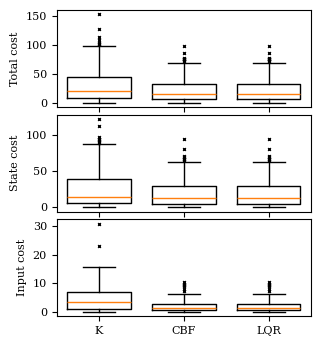

In [40]:
input_costs = (K_input_costs, cbf_input_costs, lqr_input_costs)
state_costs = (K_state_costs, cbf_state_costs, lqr_state_costs)
total_costs = (K_costs, cbf_costs, lqr_costs)
labels=('K', 'CBF', 'LQR')
flier_props=dict(marker='x', markerfacecolor='black', markersize=2,
                  linestyle='none')

fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[1]*1.75))

axs = []
axs.append(plt.subplot(3, 1, 1))
plt.boxplot(total_costs, labels=3*('',), flierprops=flier_props, positions=[0,1,2], widths=0.75);
plt.ylabel("Total cost")
axs.append(plt.subplot(3, 1, 2))
plt.boxplot(state_costs, labels=3*('',), flierprops=flier_props, positions=[0,1,2], widths=0.75);
plt.ylabel("State cost")
axs.append(plt.subplot(3, 1, 3))
plt.boxplot(input_costs, labels=labels, flierprops=flier_props, positions=[0,1,2], widths=0.75);
plt.ylabel("Input cost");

for ax in axs:
  ax.set_xlim(-0.5, 2.5)

plt.tight_layout()
fig.subplots_adjust(hspace=0.08);

""" Code for saving plots as an .eps file """
# fname="cost-boxplot.eps"
# plt.savefig(fname, dpi=600, format=None, metadata=None,
#         bbox_inches=None, pad_inches=0.0,
#         facecolor='auto', edgecolor='auto',
#         backend=None
#        )

# Small-angle Assumption

In this section we test the approach with the original nonlinear inverter connected to infinite bus system.

In [41]:
# Define the nonlinear dynamics
n_nl = 2
m_nl = 2

i_d, i_q = dynamicsymbols('i_d, i_q')
v, delta = symbols('V, \delta')
e_d, e_q = symbols('E_d, E_q')
x_nl = Matrix([[i_d], [i_q]])
Vd, Vq = v*cos(delta), v*sin(delta)
u_nl = Matrix([[Vd], [Vq]])
r, l, w, k1, k2, v, e = symbols(r'R, L, \omega, k1, k2, V, E')
A_sys_nl = Matrix([[-r/l, w], [-w, -r/l]])
B_sys_nl = Matrix([[1/l, 0], [0, 1/l]])
b_sys_nl = -B_sys_nl @ Matrix([[e_d], [e_q]])

fx_nl = A_sys_nl @ x_nl + b_sys_nl
gx_nl = B_sys_nl @ u_nl

sys_diff_eqs = latex(diff(x_nl))+'='+latex(A_sys_nl)+latex(x_nl)+'+'+latex(B_sys_nl)+latex(u_nl)+'+'+latex(b_sys_nl)
Math(sys_diff_eqs)

<IPython.core.display.Math object>

In [42]:
# Simulate the system for a range of initial conditions
from scipy.integrate import odeint

x = Matrix(MatrixSymbol("x", 2, 1))
y = Matrix(MatrixSymbol("y", 2, 1))
u = Matrix(MatrixSymbol("u", 1, 1))
x_ref = Matrix(MatrixSymbol("x^*", 2, 1))
y_ref = Matrix(MatrixSymbol("y^*", 2, 1))
hx = mag_lim**2 - (x.T @ x)[0]
Vx = ((x - x_ref).T @ (x - x_ref))[0]
fx = A_num @ x
gx = B_num

# Nonlinear system parameter dictionary
param_subs_nl = dict(param_subs)
param_subs_nl[e_d] = e_val
param_subs_nl[e_q] = 0

# Solve for the feasible x_ref, u_ref values from the nonlinear system
gx_nl_param = gx_nl.subs(param_subs_nl).subs(zip(x_nl, x)).subs(delta, u[0])
fx_nl_param = fx_nl.subs(param_subs_nl).subs(zip(x_nl, x))

eq_ref = solve(Matrix(fx_nl_param).subs(zip(x, x_ref)) + Matrix(gx_nl_param),
               [*Matrix(u), x_ref[1]], dict=True)
eq_ref = eq_ref[0] if (isinstance(eq_ref, list))   else eq_ref

xref = Matrix([[x_ref[0]], [eq_ref[x_ref[1]]]])
x0_ref = nsolve([(xref.T @ xref)[0] - mag_lim**2], [x_ref[0]], [mag_lim])[0]
x1_ref = eq_ref[x_ref[1]].subs(x_ref[0], x0_ref)
xref_maglim_val = np.array([x0_ref, x1_ref]).astype(float)

u_ctrl = eq_ref[u[0]] - (K_cbf@(x - x_ref))[0]
u_ctrl = u_ctrl.subs(param_subs_nl).subs(delta, u[0]).subs(zip(x_nl, x))

t = symbols('t')
fx_lambda_nl = lambdify([list(x), t], fx_nl_param)
gx_lambda_nl = lambdify([list(x), t, u], gx_nl_param)
u_lambda = lambdify([list(x), t, list(x_ref)], u_ctrl)


def fxdot_cbf_nl(x, t, x_ref, filter=True):
  u_ctrl = np.array([u_lambda(x, t, x_ref)])

  if filter:
    u_cbf = cbf(fa_cbf, fb_cbf, fa_clf, fb_clf, u_ctrl, x, x_ref)  # QP closed-form solution

  xdot = fx_lambda_nl(x, t) + gx_lambda_nl(x, t, u_cbf.flatten())
  return xdot.flatten()

In [43]:
dt = 1e-5
ts = np.arange(0, 0.1, dt)
n_tests = 100
rads = np.linspace(0, 2*np.pi - 2*np.pi/n_tests, n_tests)
x0s = mag_lim*np.vstack([np.sin(rads), np.cos(rads)]).T

x_ref_val = xref_maglim_val
print('x*: ', x_ref_val)

xs_vals = []
xs_vals_nl = []
for i, x0 in enumerate(x0s):
  print("Simulation: ", i+1) if (i+1) % (x0s.shape[0] // 10) == 0 else None
  xs = odeint(fxdot_cbf, x0, ts, args=(x_ref_val, True))
  xs_vals.append(xs)

  xs_nl = odeint(fxdot_cbf_nl, x0, ts, args=(x_ref_val, True))
  xs_vals_nl.append(xs_nl)

x*:  [3.42364338 3.64399039]
Simulation:  10
Simulation:  20
Simulation:  30
Simulation:  40
Simulation:  50
Simulation:  60
Simulation:  70
Simulation:  80
Simulation:  90
Simulation:  100


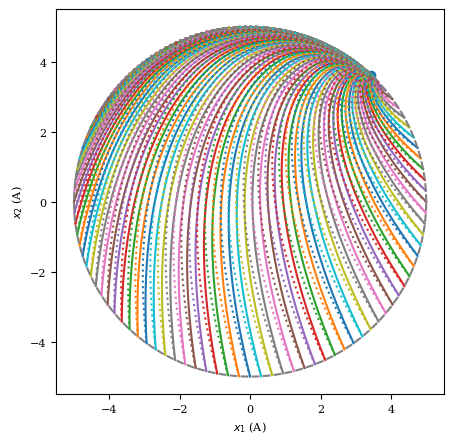

In [44]:
# Plot state trajectories
fig = plt.figure(figsize=(5,5))
rads = np.linspace(0, 2*np.pi, 100)
for xs in xs_vals:
  plt.plot(xs[:, 0], xs[:, 1]);
for xs in xs_vals_nl:
  plt.plot(xs[:, 0], xs[:, 1], linestyle=':');

plt.scatter(x_ref_val[0], x_ref_val[1])
plt.xlabel("$x_1$ (A)")
plt.ylabel("$x_2$ (A)")
plt.plot(mag_lim*np.cos(rads), mag_lim*np.sin(rads), color='grey', linestyle='--');

In [45]:
# Select an example trajectory
xs_vals_arr_cbf_all = np.array(xs_vals)
xs_vals_arr_cbf_nl_all = np.array(xs_vals_nl)

test_idxs = np.array([55])
print('x0s: ', x0s[test_idxs])
xs_vals_arr_cbf = xs_vals_arr_cbf_all[test_idxs, :, :]
xs_vals_arr_cbf_nl = xs_vals_arr_cbf_nl_all[test_idxs, :, :]

x0s:  [[-1.54508497 -4.75528258]]


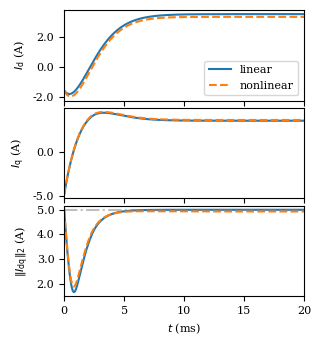

In [46]:
# Plot states versus time
colors = {"cbf": 'C0', "nl": 'C1'}
linestyles = {"cbf": '-', "nl": '--'}
fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[1]*1.75))

tms = 1000*ts  # time array in milliseconds for plotting

axs = []
axs.append(plt.subplot(3, 1, 1))
plt.plot(tms, xs_vals_arr_cbf[:, :, 0].T, label="linear", color=colors["cbf"], linestyle=linestyles["cbf"])
plt.plot(tms, xs_vals_arr_cbf_nl[:, :, 0].T, label="nonlinear", color=colors["nl"], linestyle=linestyles["nl"])
plt.ylabel("$I_\mathrm{d}$ (A)")
plt.legend()
axs.append(plt.subplot(3, 1, 2))
plt.plot(tms, xs_vals_arr_cbf[:, :, 1].T, label="linear", color=colors["cbf"], linestyle=linestyles["cbf"])
plt.plot(tms, xs_vals_arr_cbf_nl[:, :, 1].T, label="nonlinear", color=colors["nl"], linestyle=linestyles["nl"])
plt.ylabel("$I_\mathrm{q}$ (A)")
axs.append(plt.subplot(3, 1, 3))
plt.plot(tms, np.linalg.norm(xs_vals_arr_cbf[:, :, :], axis=2).T, color=colors["cbf"], linestyle=linestyles["cbf"])
plt.plot(tms, np.linalg.norm(xs_vals_arr_cbf_nl[:, :, :], axis=2).T, color=colors["nl"], linestyle=linestyles["nl"])
plt.axhline(mag_lim, color='grey', linestyle='-.', label="$I_\mathrm{lim}$", alpha=0.5)
plt.ylabel("$\|I_\mathrm{dq} \|_2$ (A)")
plt.xlabel("$t$ (ms)")

for ax in axs[:2]:
  ax.set_xticklabels([])

from matplotlib.ticker import FormatStrFormatter
for ax in axs:
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  ax.set_xlim(0, 0.02*1000)


plt.tight_layout();
fig.subplots_adjust(hspace=0.08);

In [47]:
# Recompute inputs
u_ref_val = float(eq_ref[u[0]].subs(zip(x_ref, x_ref_val)))

us_vals_cbf = []
for xs in xs_vals_arr_cbf:
  u_ctrl = u_lambda(xs.T, t, x_ref_val)
  u_cbf = np.array([cbf(fa_cbf, fb_cbf, fa_clf, fb_clf, u, x, x_ref_val) for u, x in zip(u_ctrl, xs)])
  us_vals_cbf.append(np.array(u_cbf))

us_vals_cbf_nl = []
for xs in xs_vals_arr_cbf_nl:
  u_ctrl = u_lambda(xs.T, t, x_ref_val)
  u_cbf = np.array([cbf(fa_cbf, fb_cbf, fa_clf, fb_clf, u, x, x_ref_val) for u, x in zip(u_ctrl, xs)])
  us_vals_cbf_nl.append(np.array(u_cbf))

us_vals_arr_cbf, us_vals_arr_cbf_nl = np.array(us_vals_cbf), np.array(us_vals_cbf_nl)

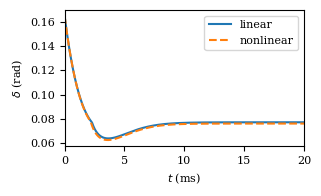

In [48]:
fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[1]))

plt.plot(tms, us_vals_arr_cbf[:, :, 0, 0].T, label="linear", color=colors["cbf"], linestyle=linestyles["cbf"])
plt.plot(tms, us_vals_arr_cbf_nl[:, :, 0, 0].T, label="nonlinear", color=colors["nl"], linestyle=linestyles["nl"])
plt.ylabel(r"$\delta$ (rad)")
plt.xlabel(r"$t$ (ms)")
# plt.axhline(u_ref_val, linestyle=':', color='grey')
plt.legend()
plt.xlim(0, 1000*0.02)
axs = fig.axes

plt.tight_layout()